In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing day-wise data of cities
cities= pd.read_csv('city_day.csv')

#visualizing the top rows of the dataset
cities.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [3]:
#getting information about the columns in our dataset
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


In [4]:
print(cities.shape)

#converting column Date into DateTime format
cities['Date']=pd.to_datetime(cities['Date'])

(29531, 16)


            Proportion
Xylene        0.613220
PM10          0.377231
NH3           0.349734
Toluene       0.272290
Benzene       0.190410
AQI           0.158511
AQI_Bucket    0.158511
PM2.5         0.155701
NOx           0.141715
O3            0.136196
SO2           0.130507
NO2           0.121398
NO            0.121296
CO            0.069723
City          0.000000
Date          0.000000


<AxesSubplot:>

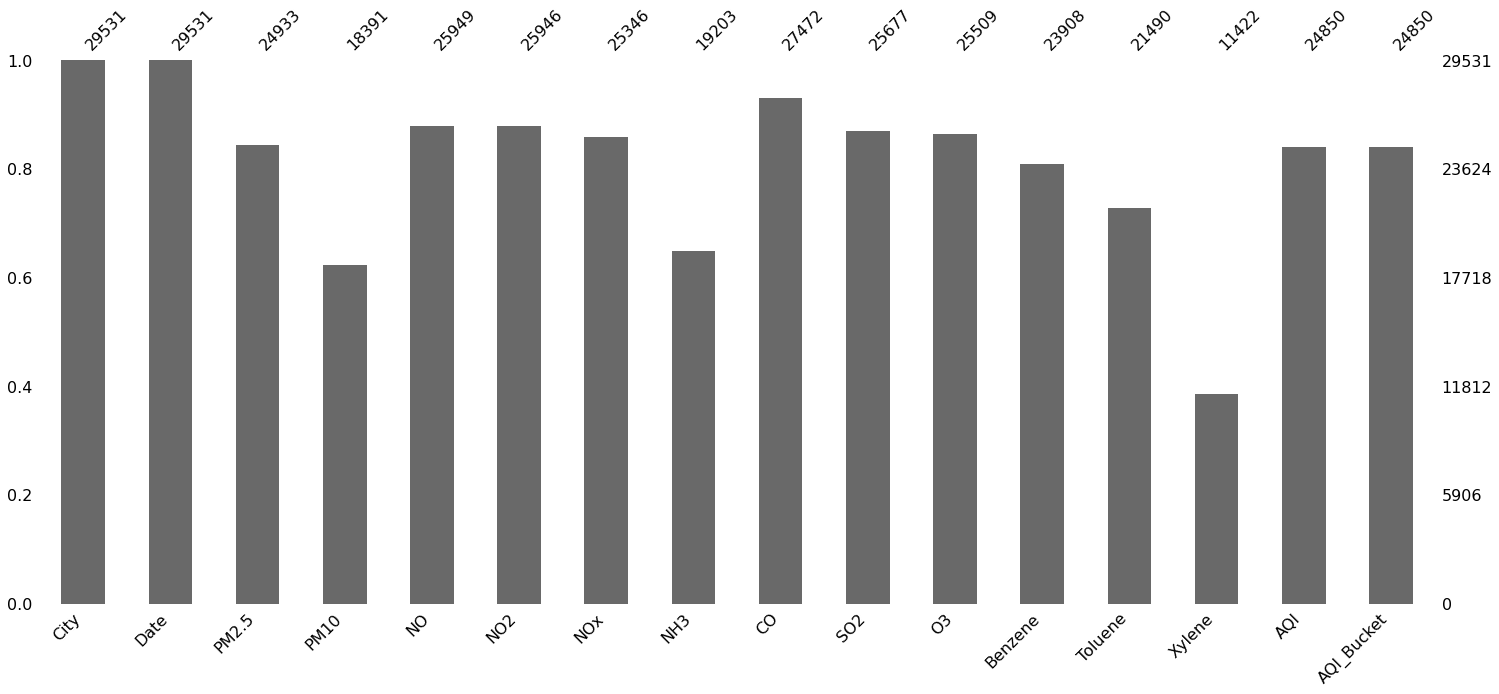

In [5]:

import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#finding the proportion of missing values in each column
missing=pd.DataFrame(cities.isna().sum()/len(cities))
missing.columns=['Proportion']
print(missing.sort_values(by='Proportion', ascending=False))

#plotting the number of non-null values in each column
msno.bar(cities)

In [6]:
#filling missing values with zero - can also be imputed by mean of the observations
cities.fillna(0,inplace=True)

#extracting year and month for each record
cities['year'] = pd.DatetimeIndex(cities['Date']).year
cities['month'] = pd.DatetimeIndex(cities['Date']).month

#clubbing all particulate matter
cities['PM']=cities['PM2.5'] + cities['PM10']

#clubbing nitrogen oxides
cities['Nitric']=cities['NO'] + cities['NO2']+ cities['NOx']

#clubbing Benzene, toluene and Xylene together
cities['BTX']=cities['Benzene'] + cities['Toluene']+ cities['Xylene']


In [7]:
#grouping pollutant levels in every city by year and month
cities_group_ym=cities.groupby(['City','year','month'])[['PM','Nitric','CO','NH3','O3','SO2','BTX','AQI']].mean()

cities_group_ym=cities_group_ym.reset_index(['City','year','month'])
cities_group_ym.head()

,City,year,month,PM,Nitric,CO,NH3,O3,SO2,BTX,AQI
0,Ahmedabad,2015,1,10.668710,88.680000,22.352258,0.0,46.350645,43.602903,6.971613,33.903226
1,Ahmedabad,2015,2,103.662143,92.985714,19.482143,0.0,43.437857,56.423214,35.357143,464.857143
2,Ahmedabad,2015,3,106.905806,80.510000,13.585484,0.0,44.276774,56.975161,41.357419,378.064516
3,Ahmedabad,2015,4,101.682000,54.992667,7.306333,0.0,31.376000,51.233333,14.496333,257.200000
4,Ahmedabad,2015,5,74.919355,50.607419,8.529677,0.0,31.624194,35.977419,19.677419,254.967742


In [8]:
cities_group_ym = cities_group_ym.drop(['BTX'], axis = 1)

### Visualizing the most polluted cities for each category of pollutants (2017-19)
We take years 2017-2019 as our reference years to understand the general trend of pollutants prevailing in some of the most polluted Indian cities:

In [9]:
#taking a subset of our dataset for the last three years before 2020

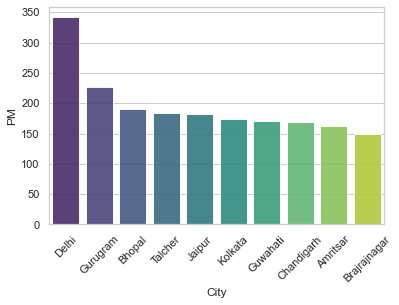

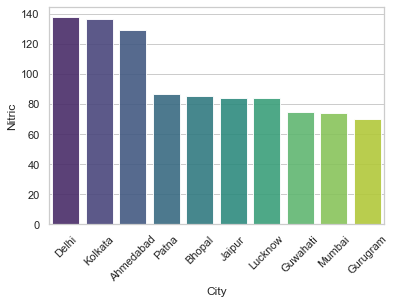

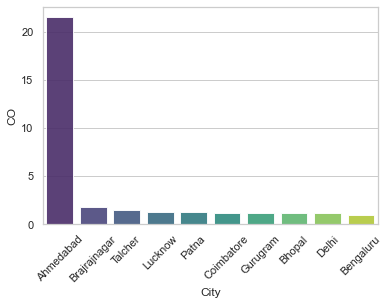

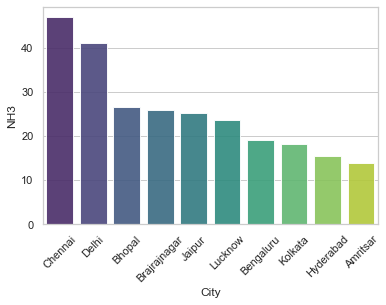

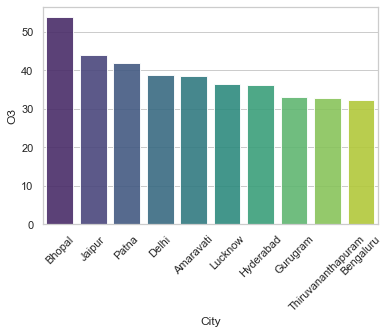

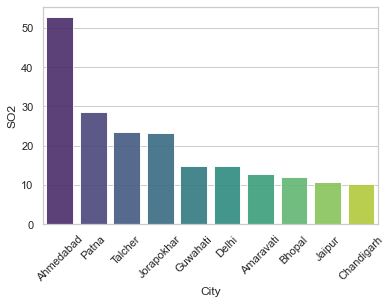

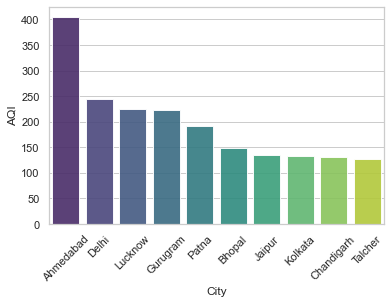

In [10]:
cities_17_19 = cities_group_ym[cities_group_ym['year'].isin([2017,2018,2019])]

#list of pollutants
pollutants = ['PM', 'Nitric', 'CO', 'NH3', 'O3', 'SO2', 'AQI']
sns.set_theme(style = 'whitegrid')

#plotting the top 10 polluted cities for each category of pollutants, as well as overall AQI
for i in pollutants:
    df = cities_17_19.groupby(['City'])[[i]].mean().sort_values(i, ascending = False).iloc[:10, :]
    df = df.reset_index(['City'])
    plt.figure()
    sns.barplot(data=df, x='City', y=i, palette = 'viridis', alpha=.9)
    plt.xticks(rotation=45)

              PM    Nitric        CO       NH3        O3       SO2       AQI
PM      1.000000  0.626912 -0.001708  0.273868  0.414142  0.194107  0.589689
Nitric  0.626912  1.000000  0.351381  0.205231  0.336590  0.398588  0.660347
CO     -0.001708  0.351381  1.000000 -0.107090  0.112073  0.658116  0.672568
NH3     0.273868  0.205231 -0.107090  1.000000  0.184410 -0.089157  0.088668
O3      0.414142  0.336590  0.112073  0.184410  1.000000  0.298710  0.404758
SO2     0.194107  0.398588  0.658116 -0.089157  0.298710  1.000000  0.591202
AQI     0.589689  0.660347  0.672568  0.088668  0.404758  0.591202  1.000000


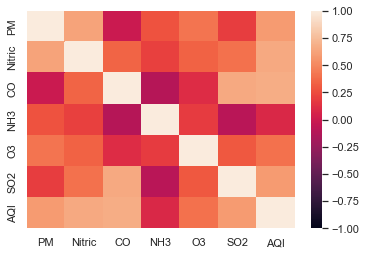

In [11]:
# Now, we try to find how each individual pollutant is related to the AQI.

# plotting the correlation matrix with sns heatmap
corr_matrix = cities_group_ym.iloc[:,3:].corr()
print(corr_matrix)
fi = plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, vmin=-1, vmax=1)
plt.show()

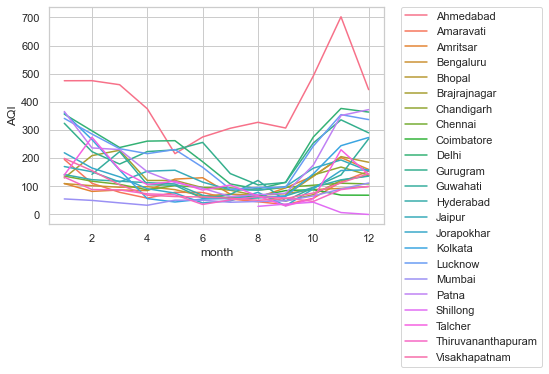

In [12]:
# Now we study the general AQI trend over themonths from year 2017-2019

df_AQI_trend = cities_17_19.groupby(['City','month'])[['AQI']].mean().reset_index()
sns.lineplot(
            data = df_AQI_trend,
            x = "month", y="AQI", hue="City"
            )
plt.legend(bbox_to_anchor=(1.05, 1),loc=2, borderaxespad = 0.)

We see that there is a clear pattern which emerges here. AQI decreases in the summer months, which in turn means that air quality improves over these months.

### Part2: Time Series Analysis and Forecasting

In [13]:
import warnings
warnings.filterwarnings('ignore')

#importing day-wise data of cities
df = pd.read_csv('city_day.csv')

df['Date'] = pd.to_datetime(df['Date'])

#visualizing the rows of the dataset
df.tail()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
29526,Visakhapatnam,2020-06-27,15.02,50.94,7.68,25.06,19.54,12.47,0.47,8.55,23.30,2.24,12.07,0.73,41.0,Good
29527,Visakhapatnam,2020-06-28,24.38,74.09,3.42,26.06,16.53,11.99,0.52,12.72,30.14,0.74,2.21,0.38,70.0,Satisfactory
29528,Visakhapatnam,2020-06-29,22.91,65.73,3.45,29.53,18.33,10.71,0.48,8.42,30.96,0.01,0.01,0.00,68.0,Satisfactory
29529,Visakhapatnam,2020-06-30,16.64,49.97,4.05,29.26,18.80,10.03,0.52,9.84,28.30,0.00,0.00,0.00,54.0,Satisfactory
29530,Visakhapatnam,2020-07-01,15.00,66.00,0.40,26.85,14.05,5.20,0.59,2.10,17.05,NaN,NaN,NaN,50.0,Good


We pivot the values from the 'City' column, so that we can have a comparitive view of the value of every city's AQI through every day.

Then we resample them to find the mean of every month, so now our dataset contains month-wise data.

In [14]:
cities_all = df.pivot_table(values='AQI', index=['Date'], columns ='City')
cities_all = cities_all.add_suffix('_AQI')
cities=cities_all.resample(rule="MS").mean()
cities.head()

City,Ahmedabad_AQI,Aizawl_AQI,Amaravati_AQI,Amritsar_AQI,Bengaluru_AQI,Bhopal_AQI,Brajrajnagar_AQI,Chandigarh_AQI,Chennai_AQI,Coimbatore_AQI,...,Jorapokhar_AQI,Kochi_AQI,Kolkata_AQI,Lucknow_AQI,Mumbai_AQI,Patna_AQI,Shillong_AQI,Talcher_AQI,Thiruvananthapuram_AQI,Visakhapatnam_AQI
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,350.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-01,520.640000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-01,418.571429,NaN,NaN,NaN,130.545455,NaN,NaN,NaN,363.800000,NaN,...,NaN,NaN,NaN,264.272727,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-01,308.640000,NaN,NaN,NaN,113.733333,NaN,NaN,NaN,175.862069,NaN,...,NaN,NaN,NaN,118.586207,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-01,263.466667,NaN,NaN,NaN,102.774194,NaN,NaN,NaN,176.129032,NaN,...,NaN,NaN,NaN,137.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
#forming a new column containing India's AQI for every month by taking the average of all cities forthe month
cities['India_AQI'] = cities.mean(axis=1)
cities.head()

City,Ahmedabad_AQI,Aizawl_AQI,Amaravati_AQI,Amritsar_AQI,Bengaluru_AQI,Bhopal_AQI,Brajrajnagar_AQI,Chandigarh_AQI,Chennai_AQI,Coimbatore_AQI,...,Kochi_AQI,Kolkata_AQI,Lucknow_AQI,Mumbai_AQI,Patna_AQI,Shillong_AQI,Talcher_AQI,Thiruvananthapuram_AQI,Visakhapatnam_AQI,India_AQI
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,350.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,346.311828
2015-02-01,520.640000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,424.284286
2015-03-01,418.571429,NaN,NaN,NaN,130.545455,NaN,NaN,NaN,363.800000,NaN,...,NaN,NaN,264.272727,NaN,NaN,NaN,NaN,NaN,NaN,258.875688
2015-04-01,308.640000,NaN,NaN,NaN,113.733333,NaN,NaN,NaN,175.862069,NaN,...,NaN,NaN,118.586207,NaN,NaN,NaN,NaN,NaN,NaN,193.815995
2015-05-01,263.466667,NaN,NaN,NaN,102.774194,NaN,NaN,NaN,176.129032,NaN,...,NaN,NaN,137.000000,NaN,NaN,NaN,NaN,NaN,NaN,193.556272


<AxesSubplot:xlabel='Date'>

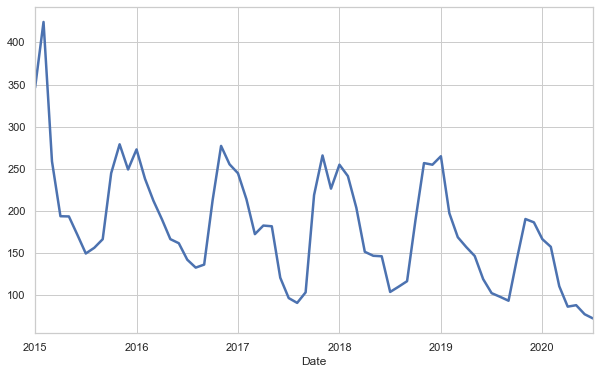

In [16]:
cities.reset_index()

sns.set_theme(style='whitegrid')

#plot India's AQI
cities['India_AQI'].plot(kind='line', grid=True, figsize=(10,6), linewidth=2.5)

From the plot above, we can visually see that there is a slight downward trend and a seasonality present. However, we will decompose the plot into trend, seasonality and residuals to get a clearer picture.

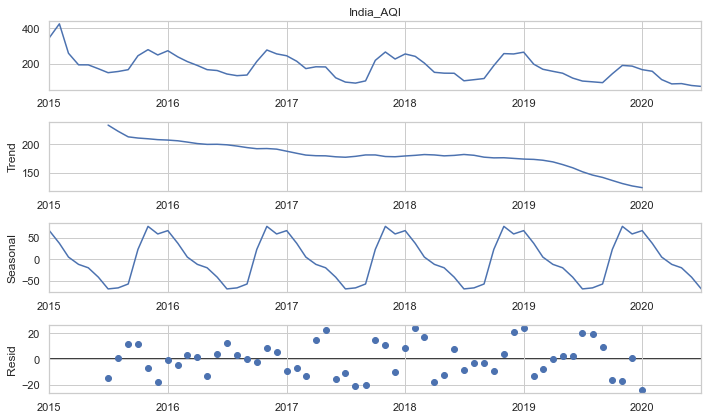

In [17]:
plt.rcParams['figure.figsize'] = (10,6)
cities['India_AQI'] = cities.mean(axis=1)
fig=seasonal_decompose(cities['India_AQI'], model='additive').plot()

We can see a clear seasonality and trend present here. The AQI decreases towards mid-year before rising again

### Augmented Dicky Fuller Test:
Augmented Dicky Fuller test is used to determine the stationarity of the time series.

In [18]:
dftest = adfuller(cities['India_AQI'], autolag = 'AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
dfoutput

Test Statistic                 -0.114224
p-value                         0.948003
#Lags Used                     10.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64

The p-value is 0.94, which means that this time series is not stationary. We perform a first order differencing to remove the trend and then perform the ADF test again.

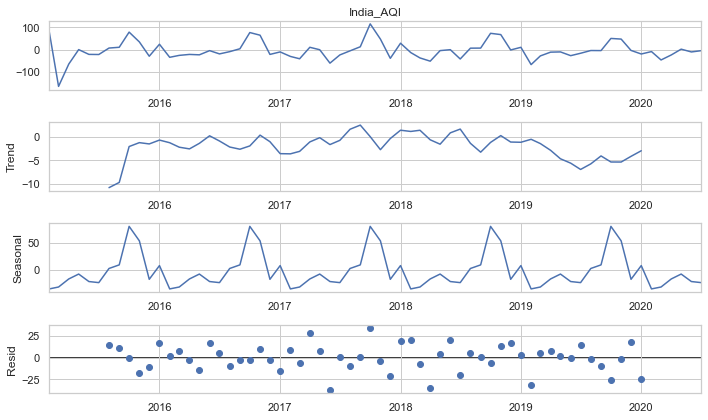

In [19]:
diff = cities['India_AQI'].diff(periods=1)
diff.dropna(inplace=True)
fig = seasonal_decompose(diff, model='additive').plot()

In [20]:
dftest = adfuller(diff)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -8.385232e+00
p-value                        2.448599e-13
#Lags Used                     9.000000e+00
Number of Observations Used    5.600000e+01
Critical Value (1%)           -3.552928e+00
Critical Value (5%)           -2.914731e+00
Critical Value (10%)          -2.595137e+00
dtype: float64

From the p-value and the Test Statistic, we can conclude that with one differencing, the time series becomes stationary. Therefore, d=1.

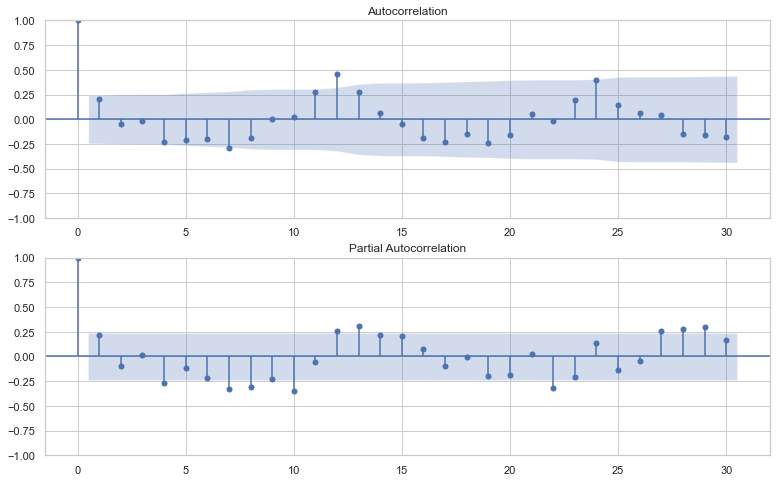

In [21]:
fig, ax = plt.subplots(2,figsize=(13, 8))
ax[0] = plot_acf(diff, lags=30, ax=ax[0])
ax[1] = plot_pacf(diff,lags=30, ax=ax[1])

In [22]:
from pmdarima import auto_arima

In [23]:
auto_arima(y=cities['India_AQI'], start_p=1, start_P=1,start_q =1, start_Q = 1, seasonal=True, m=12, stepwise=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   67
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -316.908
Date:                              Sun, 23 Apr 2023   AIC                            643.816
Time:                                      12:26:47   BIC                            654.765
Sample:                                  01-01-2015   HQIC                           648.143
                                       - 07-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0189      0.059      0.320      0.749      -0.097       0.135
ma.L2         -0.8363      0.069    -12.077      0.000      -0.972      -0.701
ar.S.L12       0.9444      0.062     15.221      0.000       0.823       1.066
ma.S.L12      -0.5623      0.229     -2.458      0.014      -1.011      -0.114
sigma2       694.3699    142.982      4.856      0.000     414.130     974.609
===================================================================================
Ljung-Box (L1) (Q):                   0.95   Jarque-Bera (JB):                 2.99
Prob(Q):                              0.33   Prob(JB):                         0.22
Heteroskedasticity (H):               0.38   Skew:                            -0.52
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:

#dividing into train and test:
train_data=cities['India_AQI'][:'2018-12']
test_data=cities['India_AQI'][:'2019-12']

#Building the model:
model=SARIMAX(train_data,order=(0,1,2),seasonal_order=(1,0,1,12), trend='n')
results=model.fit()

#printing summry of model reults
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            India_AQI   No. Observations:                   48
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -229.813
Date:                              Sun, 23 Apr 2023   AIC                            469.625
Time:                                      12:26:48   BIC                            478.876
Sample:                                  01-01-2015   HQIC                           473.106
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0647      0.646      0.100      0.920      -1.202       1.331
ma.L2         -0.9325      0.633     -1.474      0.140      -2.172       0.307
ar.S.L12       0.9183      0.097      9.440      0.000       0.728       1.109
ma.S.L12      -0.4473      0.301     -1.485      0.138      -1.038       0.143
sigma2       766.9984    477.906      1.605      0.109    -169.680    1703.677
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 3.61
Prob(Q):                              0.63   Prob(JB):                         0.16
Heteroskedasticity (H):               0.24   Skew:                            -0.66
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

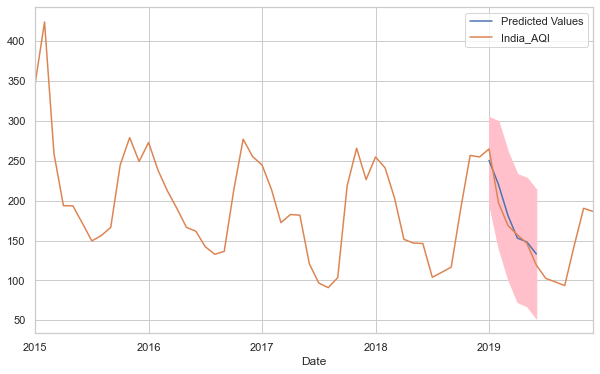

In [25]:
fig, ax= plt.subplots(figsize=(10,6))

#predict the next 24 months values to compare with the test dataset
forecasts = results.get_forecast(steps=6, dynamic=True)

#find the confidence intervals
confidence_intervals=forecasts.conf_int()
lower_limits = confidence_intervals.loc[:,'lower India_AQI']
upper_limits = confidence_intervals.loc[:,'upper India_AQI']

#plot the forecasted mean data for the next 12 months and the confidence interval
forecasts.predicted_mean.plot(legend=True, ax=ax, label ='Predicted Values')
plt.fill_between(confidence_intervals.index, lower_limits, upper_limits, color='pink')

#plotting the actual value from test data
test_data.plot(legend=True, ax=ax)


In [26]:
from sklearn.metrics import mean_squared_error

test= cities['India_AQI']['2021-01':'2021-12']
RMSE=np.sqrt(mean_squared_error(forecasts.predicted_mean,test))
print('RMSE = ',RMSE)

y_true=test
y_pred= forecasts.predicted_mean
mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print('MAPE = ', mape)

ValueError: Found input variables with inconsistent numbers of samples: [6, 0]

<AxesSubplot:xlabel='Date'>

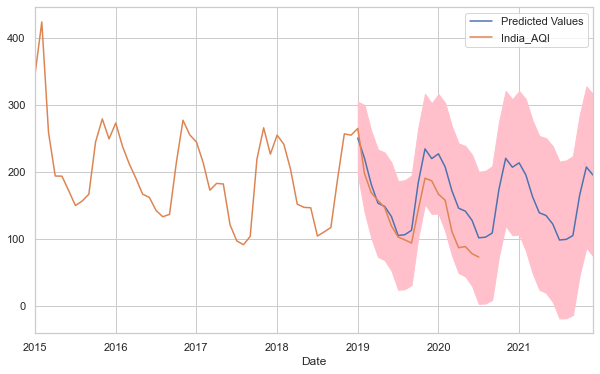

In [27]:
fig, ax= plt.subplots(figsize=(10,6))

forecasts = results.get_forecast(steps=36, dynamic=True)

confidence_intervals=forecasts.conf_int()
lower_limits = confidence_intervals.loc[:,'lower India_AQI']
upper_limits = confidence_intervals.loc[:,'upper India_AQI']

#plot the forecasted data
forecast_data = forecasts.predicted_mean
forecast_data.plot(legend=True, ax=ax, label ='Predicted Values')

#plot the confidence interval as the shaded area
plt.fill_between(confidence_intervals.index, lower_limits, upper_limits, color='pink')

#Plot India's AQI Data
cities['India_AQI'].plot(legend=True, ax=ax)

In [28]:
forecast_data

2019-01-01    250.586367
2019-02-01    220.301093
2019-03-01    181.542532
2019-04-01    153.112078
2019-05-01    148.288093
2019-06-01    133.230561
2019-07-01    104.801417
2019-08-01    105.950199
2019-09-01    112.668100
2019-10-01    184.036361
2019-11-01    234.345182
2019-12-01    219.847335
2020-01-01    227.008966
2020-02-01    207.340216
2020-03-01    171.747050
2020-04-01    145.638499
2020-05-01    141.208488
2020-06-01    127.380698
2020-07-01    101.273350
2020-08-01    102.328312
2020-09-01    108.497564
2020-10-01    174.037210
2020-11-01    220.237330
2020-12-01    206.923517
2021-01-01    213.500260
2021-02-01    195.437848
2021-03-01    162.751562
2021-04-01    138.775285
2021-05-01    134.707071
2021-06-01    122.008591
2021-07-01     98.033419
2021-08-01     99.002222
2021-09-01    104.667635
2021-10-01    164.854685
2021-11-01    207.281661
2021-12-01    195.055181
Freq: MS, Name: predicted_mean, dtype: float64

In [29]:
import pickle

with open('Air_Pollution_web_on_pickle.pkl', 'wb') as file:
    pickle.dump(forecasts, file)

In [ ]:
!python --version

Python 3.8.5
